In [2]:
import copy
from scipy.spatial import cKDTree
import numpy as np
from queue import PriorityQueue
import math


# Planning

def bounded(l):
  return -1 < l[0] and l[0] < 360 and -90 < l[1] and l[1] < 90

def neighbors(l, tree, points):
  neighbors = []
  directions = [(0.0625, 0), (-0.0625, 0), (0, 0.0625), (0, -0.0625)]
  for d in directions:
    dx, dy = l[0] + d[0], l[1] + d[1]
    if bounded((dx, dy)) and len(tree.query_ball_point((dx, dy), 2)) == 0:
      neighbors.append((dx, dy))
  return neighbors

def heuristic(current, goal):
  """Current and goal are both tuples of form (x, y)"""
  return np.abs(current[0] - goal[0]) + np.abs(current[1] - goal[1])
  # return np.sqrt((current[0] - goal[0])**2 + (current[1] - goal[1])**2)

def pathfind(start, end, points):
  # Breadth-first Search with Path Tracking
  tree = cKDTree(points)

  frontier = PriorityQueue()
  frontier.put((0, start))
  came_from = {start: None}
  while frontier:
    c = frontier.get()[1]
    if c == end:
      break
    for n in neighbors(c, tree, points):
      if n not in came_from:
        frontier.put((heuristic(n, end), n))
        came_from[n] = c

  # Reconstruct
  c, path = end, []
  while c != start:
    path.append(c)
    c = came_from[c]
  path.reverse()
  return path

def slope(p1, p2):
  dx = p2[0]-p1[0]
  dy = p2[1]-p1[1]
  
  if dx != 0:
    return 1
  elif dy != 0:
    return -1

def diff(l):
  return [slope(l[i], l[i+1]) for i in range(len(l)-1)] + [slope(l[-2], l[-1])]

In [3]:
#Perform coordinate transformation from horizontal to equatorial


# A = azimuth, a = altitude, RA = alpha, t = local sidereal time, phi = observer's latitude, delta = declination

def time2degrees(h, m, s):
  return h*15 + m/4 + s/240

def arc2degrees(deg, amin, asec):
  return deg + amin/60 + asec/3600

# A = azimuth, h = altitude, RA = alpha, theta = local sidereal time, phi = observer's latitude, delta = declination
def transform_coords(h, A, phi, theta):
  h = np.radians(h)
  A = np.radians(A)
  phi = np.radians(phi)

  #H = np.degrees(np.arctan(np.sin(A) / (np.cos(A)*np.sin(phi) + np.tan(h)*np.cos(phi))))
  
  delta = np.degrees(np.arcsin(np.sin(phi)*np.sin(h) - np.cos(phi)*np.cos(h)*np.cos(A)))
  H = np.arccos((np.sin(h)-np.sin(phi)*np.sin(np.radians(delta)))/(np.cos(phi)*np.cos(np.radians(delta))))
  H = np.degrees(H) # split to make easier to read
  #H = 360 - H if np.sin(A) > 0 else
  
  alpha = theta - H
  alpha = alpha + 360 if alpha < 0 else alpha

  return (alpha, delta)

th = 51.67147
print(f"(alpha, delta) = {transform_coords(15.1249, 68.0337, arc2degrees(38, 55, 17), th)}")
print(" ")

print(f"The right ascension should be: {time2degrees(23, 9, 16.641)}")
print(f"The declination should be: {arc2degrees(-6, -43, -11.61)}")


(alpha, delta) = (347.3193518403506, -6.719869425191557)
 
The right ascension should be: 347.3193375
The declination should be: -6.719891666666666


When using an unweighted graph as we are, the pathfinding has no issues planning a path that goes right next to the no-go zone. This is a problem as even getting close to the no-go zone should probably be prevented. This problem is usually solved with a weighted graph and a pathfinding algorithm that chooses the 'cheapest' path. In this case, cost would be a value reflective of how close a particular node is to an inaccessible one.

However, this is annoying to implement. We could, but a cheaper and simpler way to handle this (until we do need something more complex) is to simply set the nodes around the no-go zone as also being inaccessible. We simply set the cells within radius $r$ around each no-go zone as also being inaccessible. We maintain this original graph for drawing (so we can see how the path is avoiding the *actual* no-go zones instead of the 'imaginary' no-go zones) but create a deep copy of it to mutate as the version we actually use for pathfinding. It should be noted that the original graph is not used for anything except for plotting, and that only the mutated graph is necessary for plotting a valid path that the mount can then follow.

**Todo**: Currently, the only obstacle on the graph is an artificial line drawn through three-fourths of the addressable azimuths at half of the maximum elevations. We need to load the shapes in from the coordinates marked down as being no-go zones and use that for path finding. 

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('coords.txt', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
data[['x']] = np.round(data[['x']], decimals=3)
data[['y']] = np.round(data[['y']], decimals=3)

g = list(data.to_records(index=False))

#g = [(x, 45) for x in range (90, 270)]
#g = [(np.random.randint(360), np.random.randint(90)) for i in range(0, 100)

g = list(map(lambda coord: transform_coords(coord[1], coord[0], 41.8352026, time2degrees(8, 32, 1)), g))
print(g)

[(37.98002285127933, -0.2189109864782131), (119.03287452125404, -47.81409531062722), (37.98108026704327, -0.2125957857192095), (119.03435355787644, -47.81421148645122), (37.98131452160759, -0.20835962501286542), (119.03435355787644, -47.81421148645122), (77.18085800585621, 80.37670950503701), (127.2640657949012, -48.3344298508205), (112.6947500242154, 53.62936598396489), (127.3623420734393, -19.453917961669397), (99.8645410224618, 51.65234674043396), (126.78135170382804, -20.90158080419013), (37.991527223277714, -0.11331919714562366), (119.04470699946846, -47.815024185265585), (62.91059985275797, 46.381597312853835), (124.80248926737646, -36.01667335089565), (111.02058934734458, 55.209576464623034), (127.31329624975031, -21.258554182197532), (14.336904983146525, 81.24671935836945), (126.99175527862417, -57.88820326510962), (317.2515186300119, 48.34101826469913), (312.3900822539794, -84.60088186815395), (37.98824125850163, -0.1471304519482626), (119.04026977053198, -47.814675999765406),

Now we have a simple function to run the pathfinding, draw a polar plot with the actual no-go zones, and the path that was found over the 'imaginary' no-go zone graph. The starting and end positions are added as different colored points.

221.6875


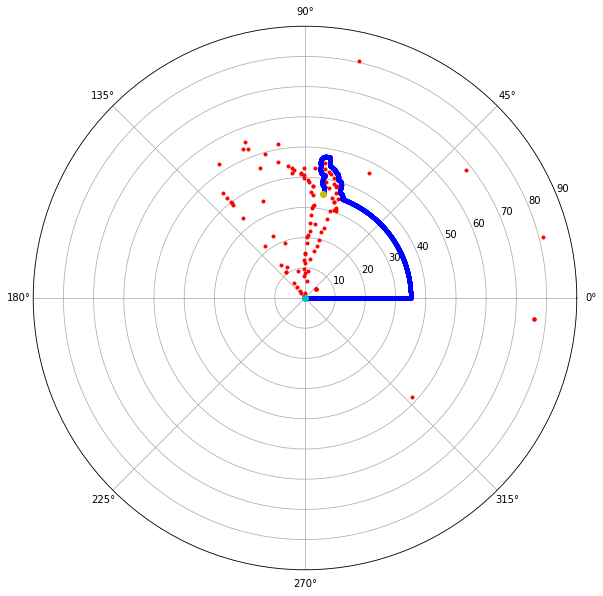

[[0, 0], [0, 35.0], [69.375, 35.0], [69.375, 35.1875], [69.4375, 35.1875], [69.4375, 35.375], [69.5, 35.375], [69.5, 35.5], [69.5625, 35.5], [69.5625, 35.625], [69.625, 35.625], [69.625, 35.75], [69.6875, 35.75], [69.6875, 35.8125], [69.75, 35.8125], [69.75, 35.9375], [69.8125, 35.9375], [69.8125, 36.0], [69.875, 36.0], [69.875, 36.0625], [69.9375, 36.0625], [69.9375, 36.125], [70.0, 36.125], [70.0, 36.1875], [70.125, 36.1875], [70.125, 36.25], [70.1875, 36.25], [70.1875, 36.3125], [70.3125, 36.3125], [70.3125, 36.375], [70.375, 36.375], [70.375, 36.4375], [70.5625, 36.4375], [70.5625, 36.5], [70.6875, 36.5], [70.6875, 36.5625], [70.9375, 36.5625], [70.9375, 36.625], [71.625, 36.625], [71.625, 36.75], [71.6875, 36.75], [71.6875, 36.9375], [71.75, 36.9375], [71.75, 37.0625], [71.8125, 37.0625], [71.8125, 37.1875], [71.875, 37.1875], [71.875, 37.25], [71.9375, 37.25], [71.9375, 37.375], [72.0, 37.375], [72.0, 39.0], [72.0625, 39.0], [72.0625, 39.25], [72.125, 39.25], [72.125, 39.375], [7

In [8]:
# Plotting Utilities

def inaccessible(g):
  inaccessibles = []
  for x, d1 in g.items():
    for y, d2 in d1.items():
      inaccessibles.append((x, y))
  return inaccessibles

# Plotting

import matplotlib.pyplot as plt
import numpy as np

def path2point(start, end, pathfinding_graph, drawing_graph):
  path = pathfind(start, end, g)

  plt.figure(figsize=(10, 10))
  plt.axes(projection = 'polar')

  inaccessible_points = list(zip(*g))
  path_points = list(zip(*path))
  plt.polar(np.array(inaccessible_points[0]) * (np.pi/180), inaccessible_points[1], 'r.')
  plt.polar(np.array(path_points[0]) * (np.pi/180), path_points[1], 'b.')
  plt.polar(start[0] * (np.pi/180), start[1], 'co', end[0] * (np.pi/180), end[1], 'yo')

  plt.ylim([0, 90])
  plt.show()

#%prun path2point((229,0), (142,250), g, g)

# Denobola is RA 11h 49m 4s | Dec +14° 34′ 19″

def round16(n):
  '''Round to nearest 1/16th'''
  return math.floor(n*16)/16

print(round16(time2degrees(8+6, 46, 48)))
#path2point((round16(time2degrees(14, 46, 48)), 0), (round16(time2degrees(11, 49, 4)), round16(arc2degrees(14, 34, 19))), g, g)

path2point((0, 0), (80, 35), g, g)


def prune(start, end, path):
  # TEMPORARY CHANGE: easier for swift to ingest [] rather than () 
  prunedPath = [list(start)]
  for i in np.argwhere(np.diff(diff(path))).flatten():
    prunedPath.append(list(path[i+1]))
  prunedPath.append(list(end))
  return prunedPath

denebola = (round16(time2degrees(11, 49, 4)), round16(arc2degrees(14, 34, 19)))

#path = pathfind((round16(time2degrees(14, 46, 48)), 0), denebola, g)
#print(path)
path = pathfind((0, 0), (80, 35), g)
pruned = prune((0, 0), (80, 35), path)
print(pruned)

## Code for showing pruned path in a way that Swift can ingest

#print('[', end='')
#for prune in pruned:
#  print(f'[{prune[0]} : {prune[1]}], ', end='')
#print(']', end='')



# Moving the Telescope Along the Path: #

(*This is just for testing, the telescope will be moved by the Python team upon completion*)

Once a path for the telescope has been made, the code will identify the 'corners' of the path. The telescope will then be moved in one direction until it has come close to the first 'corner'. The code will monitor its current position while moving. Once the telescope is close to the desired position, the telescope will be slowed down to prevent it from overshooting. Once the 'corner' has been reached, the telescope will stop and move towards the next 'corner'. This process will continue until it reaches it's final destination.

In [ ]:
# # Moving North/South
# self.mount.getSwitchVector("MOUNT_MOTION_DEC").update({"NORTH": "On", "SOUTH": "Off"})

# # Moving East/West
# self.mount.getSwitchVector("MOUNT_MOTION_RA").update({"WEST": "On", "EAST": "Off"}

# # Moving to a point
# self.telescopeClient.gotoCoords(ra, dec)

###########################################################################

# Moving North to a corner

# current_position = 1 # Replace with telescope coordinates from Mount
# path_corner = 5 # Corner of path we want to go to

# self.mount.getSwitchVector("MOUNT_MOTION_DEC").update({"NORTH": "On", "SOUTH": "Off"})
# while current_position != path_corner:
#   current_position = 4 # Insert updated coordinates from mount
# self.mount.getSwitchVector("MOUNT_MOTION_DEC").update({"NORTH": "Off", "SOUTH": "Off"})

                                                  


```for point in points:

  direction_to_move = d2m(current_position(), radec_point)

  move(direction_to_move)

  while distance(queryDirection(), radec_point) > 0.05:

    pass

  stop_move()```